**概要：**  
・顔画像から、happy,natural,angryの3つの感情を認識をする  
・JAFFEデータセットを使用  
・VGG16への転移学習を行う  
・trainデータ、validationデータ、testデータにわけ、testデータの分類の通りの感情が最も高い数値で判定されれば判定成功とする  


**工夫点：**  
・画像を反転させるなどしてデータ数を増やした  
・使用データ数、バッチサイズ、エポック数を調整することで精度向上が見込まれた  
・学習過程をグラフで表現したり、結果を見えるように工夫した


**結果の考察（改善点）：**  
・testデータの分類通りの感情が最も高い数値で判定されるようになった  
・データ数が少ないとのエラーが出て、当初の予定よりデータ数、バッチサイズ、エポック数を調整したため、学習過程を見ると安定して下がっていないように見えるケースがあった  

In [ ]:
import os
import sys
import glob

import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.layers import Dense, Flatten, Input, Activation, add
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 学習済みネットワーク
from keras.applications.vgg16 import VGG16\

In [ ]:
# 分類
emotions = ['happy', 'natural', 'angry'] # 分類したい項目名（ディレクトリ名）
emotion_count = len(emotions)

image_width, image_height = 150, 150

# datasetディレクトリ
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Colab Notebooks/AVILEN演習課題/プロダクト課題/dataset'

train_data_path = str(dataset_path) + '/train' 
validation_data_path = str(dataset_path) + '/validation' 
test_data_path = str(dataset_path) + '/test' 

# 重みデータを保存するディレクトリ
result_dir = '/content/drive/My Drive/Colab Notebooks/AVILEN演習課題/プロダクト課題'

# データの枚数　###バッチサイズ、エポック数の関係でデータが多いとエラーが発生する###
train_data_count = 6
validation_data_count = 3

# バッチサイズ、エポック数
batch_size = 10
epoch_count = 20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


データセットの階層  
dataset  
 |-train  
 | |-happy  
 | |-natural  
 | |-angry  
 |-validation  
 | |-happy  
 | |-natural  
 | |-angry  
 |-test  
 | |-happy  
 | |-natural  
 | |-angry  

In [ ]:
# データ生成
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.39,
    horizontal_flip=True,
    samplewise_center=False,
    samplewise_std_normalization =False,
    zca_whitening=False)

In [ ]:
generator_train = datagen.flow_from_directory(
    train_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True)

generator_validation = datagen.flow_from_directory(
    validation_data_path, 
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

Found 60 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [ ]:
# VGG16学習済みモデルの読み込み(RGB)
input_tensor = Input(shape=(image_width, image_height, 3))
learned_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の作成
full_model = Sequential()
full_model.add(Flatten(input_shape=learned_model.output_shape[1:]))
full_model.add(Dense(256, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(emotion_count, activation='softmax'))

# 学習済みデータと全結合層を結合
model = Model(inputs=learned_model.input, outputs=full_model(learned_model.output))

# 全結合層直前までの層を学習しないようにする
for layer in learned_model.layers[:15]:
    layer.trainable = False

# 学習処理の設定
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
    metrics=['accuracy'])

In [ ]:
# 学習
result = model.fit_generator(
    generator_train,
    steps_per_epoch=train_data_count,
    epochs=epoch_count,
    validation_data=generator_validation,
    validation_steps=validation_data_count)

# 重みを保存
model.save_weights(os.path.join(result_dir, 'weight.h5'))

Epoch 1/20
6/6 [==============================] - 1s 138ms/step - loss: 1.1995 - accuracy: 0.2833 - val_loss: 1.0278 - val_accuracy: 0.4000
Epoch 2/20
6/6 [==============================] - 1s 96ms/step - loss: 1.0882 - accuracy: 0.3500 - val_loss: 1.0565 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 91ms/step - loss: 1.0678 - accuracy: 0.4833 - val_loss: 1.0533 - val_accuracy: 0.5333
Epoch 4/20
6/6 [==============================] - 1s 91ms/step - loss: 1.0360 - accuracy: 0.5167 - val_loss: 0.9819 - val_accuracy: 0.4667
Epoch 5/20
6/6 [==============================] - 1s 92ms/step - loss: 1.0870 - accuracy: 0.4000 - val_loss: 1.2932 - val_accuracy: 0.4667
Epoch 6/20
6/6 [==============================] - 1s 92ms/step - loss: 0.9969 - accuracy: 0.4833 - val_loss: 0.8434 - val_accuracy: 0.6000
Epoch 7/20
6/6 [==============================] - 1s 92ms/step - loss: 0.8223 - accuracy: 0.6333 - val_loss: 0.5071 - val_accuracy: 0.8667
Epoch 8/20
6/6 [==========

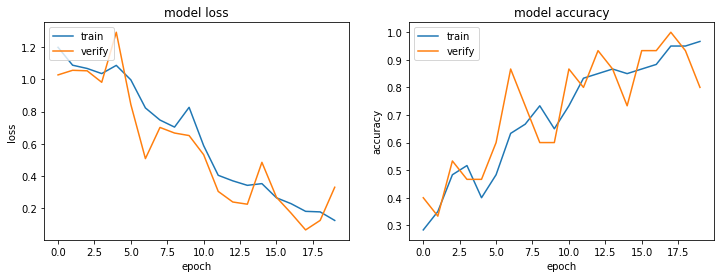

In [ ]:
fig = plt.figure(figsize=(12,4))

# subplot
# loss
sub_loss = fig.add_subplot(1,2,1)
sub_loss.plot(result.history['loss'])
sub_loss.plot(result.history['val_loss'])
sub_loss.set_title('model loss')
sub_loss.set_ylabel('loss')
sub_loss.set_xlabel('epoch')
sub_loss.legend(['train', 'verify'], loc='upper left')

#Accuracy
sub_acc = fig.add_subplot(1,2,2)
sub_acc.plot(result.history['accuracy'])
sub_acc.plot(result.history['val_accuracy'])
sub_acc.set_title('model accuracy')
sub_acc.set_ylabel('accuracy')
sub_acc.set_xlabel('epoch')
sub_acc.legend(['train', 'verify'], loc='upper left')

In [ ]:
def test_predict(filepath_list):

    for i in filepath_list:
        # 画像を読み込んで4次元テンソルへ変換
        img = image.load_img(i, target_size=(image_height, image_width))
        xarray = image.img_to_array(img)
        x = np.expand_dims(xarray, axis=0)
        # テストデータも正規化
        x = x / 255.0

        # 予測 入力は1枚の画像なので[0]のみ
        pred = model.predict(x)[0]
        
        # 描画　topの数だけ予測確率が高い結果を出力
        fig = plt.figure(figsize=(2,2))
        top = 3
        top_indices = pred.argsort()[-top:][::-1]
        result = [(emotions[i], pred[i]) for i in top_indices]
        [print(x) for x in result]
        plt.imshow(img)
        plt.show()
        
        print('------------------------------------')



<<HAPPY>>

('happy', 0.99812084)
('natural', 0.0018788622)
('angry', 1.8301968e-07)


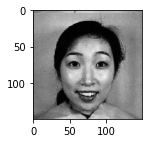

------------------------------------
('happy', 0.67531645)
('natural', 0.32459903)
('angry', 8.449259e-05)


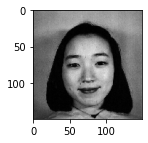

------------------------------------
('happy', 0.9999076)
('natural', 9.2220216e-05)
('angry', 1.5905718e-07)


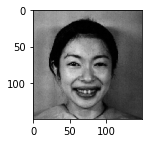

------------------------------------
('happy', 0.9998932)
('natural', 0.00010665714)
('angry', 1.6402889e-07)


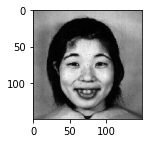

------------------------------------
('happy', 0.99970907)
('natural', 0.00029005052)
('angry', 8.097148e-07)


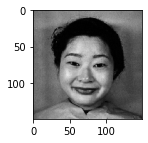

------------------------------------


<<NATURAL>>

('natural', 0.98413473)
('happy', 0.01566885)
('angry', 0.00019642328)


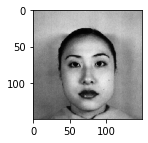

------------------------------------
('happy', 0.8008034)
('natural', 0.19913907)
('angry', 5.7425466e-05)


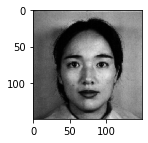

------------------------------------
('natural', 0.706289)
('happy', 0.29318756)
('angry', 0.0005234839)


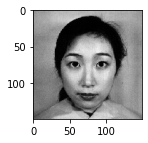

------------------------------------
('natural', 0.9440786)
('happy', 0.05562859)
('angry', 0.0002926749)


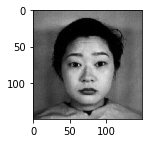

------------------------------------
('natural', 0.99702543)
('happy', 0.002843516)
('angry', 0.00013104151)


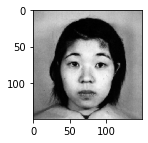

------------------------------------


<<ANGRY>>

('natural', 0.77611923)
('angry', 0.11301998)
('happy', 0.11086076)


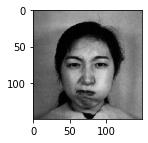

------------------------------------
('angry', 0.6226519)
('natural', 0.37718692)
('happy', 0.00016115142)


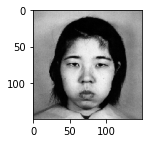

------------------------------------
('angry', 0.99857414)
('natural', 0.0014236594)
('happy', 2.1427975e-06)


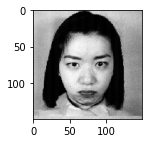

------------------------------------
('natural', 0.6933368)
('angry', 0.30597073)
('happy', 0.0006924562)


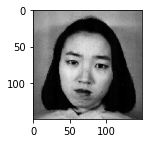

------------------------------------
('angry', 0.8876283)
('natural', 0.08347416)
('happy', 0.028897481)


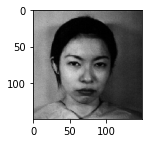

------------------------------------


In [ ]:
for x in emotions:
    print('\n\n<<'+ str(x).upper() + '>>\n')
    filepath_list = glob.glob(str(test_data_path)  + '/' + str(x) + '/*')
    test_predict(filepath_list)

**リファレンス**  
[The Japanese Female Facial Expression (JAFFE) Dataset](https://zenodo.org/record/3451524#.X5JTB0IzauU)  
[Keras(Tensorflow)の学習済みモデルのFine-tuningで少ない画像からごちうさのキャラクターを分類する分類モデルを作成する](https://qiita.com/kazuki_hayakawa/items/c93a21313ccbd235b82b)  
[VGG16のFine-tuningによる17種類の花の分類](https://aidiary.hatenablog.com/entry/20170131/1485864665)   
[「少ないデータで転移学習を用いて画像内の表情を分類する」](https://github.com/zarakima/face-classification)   